# Spring 2022 AZMP Drifter Deployment Plan

We plan to deploy several drifters at AZMP stations during the Spring 2022 cruise. This document outlines the drifter inventory and ideal deployment locations.

Tentative Dates: April 8-May 1, 2022

## Goals
* Create an inventory of drifter data on NL Shelf for model evaluation
* Collect observed wave data on the NL Shelf for comparison with wave models
* Collect observations of veritcal current shear in upper 15m of NL Shelf
* Collect observations of surface temperatures on NL Shelf
* Compare drift characteristics between Stokes and Oskers
* Examine bifurcation of Labrador current along Bonvista transect
* Test deployment strategy in preparation for SWOT Spring 2023


## Drifter Inventory
| Name       | Type    | Quantity | Data collected                |
|------------|---------|----------|-------------------------------|
| Osker      | Surface | 4        | Position                      |
| Stokes     | Surface | 6        | Position/Temperature          |
| Code/Davis | Drogued | 1        | Position/Temperature          |
| iSVP       | Drogued | 2        | Position/Temperature/Pressure |
| Spotter    | Wave    | 1        | Position/Temperature/Waves    | 


## Deployment locations

In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import xarray as xr

%matplotlib inline

In [2]:
lat_min=45
lon_min=-55
lat_max=52
lon_max=-45

In [3]:
# Glorys climatology
f='/home/soontiensn/remote2/hank/climatology/glorys12/monthly/mercatorglorys12v1_gl12_mean_04_199301-201812.nc'
d = xr.open_dataset(f)
dsel = d.isel(depth=0,time=0).sel(latitude=slice(lat_min,lat_max), longitude=slice(lon_min, lon_max)) 
uvel = dsel.uo.values
vvel = dsel.vo.values
lat = dsel.latitude.values
lon = dsel.longitude.values
lon, lat = np.meshgrid(lon, lat)

In [4]:
# etopo file
ef = '/home/soontiensn/data/ocn-nav/ETOPO1_Bed_g_gmt4.grd'
etopo = xr.open_dataset(ef)
esel = etopo.sel(x=slice(lon_min, lon_max), y=slice(lat_min, lat_max))

In [5]:
def plot_map(ax):
    bmap = Basemap(projection='merc',llcrnrlon=lon_min, urcrnrlon=lon_max,
                   llcrnrlat=lat_min,urcrnrlat=lat_max, ax=ax,resolution='i')
    bmap.drawcoastlines()
    bmap.fillcontinents(color='grey',)
    bmap.drawparallels(np.arange(lat_min, lat_max, 5.),labels=[1,0,0,0])
    bmap.drawmeridians(np.arange(lon_min, lon_max,5.),labels=[0,0,0,1])
    return bmap

In [6]:
def plot_quivers(bmap, ax, xvel,yvel,lat,lon,st=10):
    mag = np.sqrt(xvel**2+yvel**2)
    mesh=bmap.pcolormesh(lon,lat,mag,latlon=True,vmin=0,vmax=1,cmap='YlGnBu_r')
    q=bmap.quiver(lon[::st,::st],lat[::st,::st],xvel[::st,::st],yvel[::st,::st],latlon=True,scale=10,color='lightgrey')
    ax.quiverkey(q,0.05,0.4,0.5,'0.5 m/s',color='lightgrey')
    cbar=plt.colorbar(mesh, ax=ax)
    cbar.set_label('speed [m/s]')

In [7]:
def plot_transects(bmap,ax,transects):
    for transect in transects:
        lons = np.array([transects[transect]['start'][0],
                         transects[transect]['end'][0]])
        lats = np.array([transects[transect]['start'][1],
                         transects[transect]['end'][1]])
        x,y = bmap(lons, lats)
        bmap.plot(x,y,'-r')

In [8]:
def plot_stations(bmap,ax,stations):
    for station in stations:
        lon = stations[station][0]
        lat = stations[station][1]
        x,y = bmap(lon, lat)
        if 'BB' in station:
            marker='o'
        else:
            marker = 's'
        bmap.plot(x,y,marker, label=station)

In [9]:
def plot_bathymetry(bmap, ax, etopo):
    lons = etopo.x.values
    lats = etopo.y.values
    lons, lats = np.meshgrid(lons,lats)
    x, y = bmap(lons, lats)
    bathy = etopo.z.values
    levels = [-500, -100,]
    CS = bmap.contour(x,y,bathy,levels, linestyles='solid', linewidth=0.1,colors='black')
    ax.clabel(CS, CS.levels, inline=True, fmt='%1.0f', fontsize=12)

In [10]:
transects = {
    'BB': {'start': [-52.9666666666667,48.7333333333333],
           'end': [-47.9466666666667,50.3316666666667]},
}
stations = {
    'BB-01 \n  1 Osker \n  1 Stokes ': [-52.9666666666667,48.7333333333333],
    'BB-02 \n  1 Osker \n  1 Stokes ': [-52.75,48.8],
    'BB-03 \n  1 Osker \n  1 Stokes \n  1 iSVP ': [-52.65,48.8333333333333],
    'BB-04 \n  1 Osker \n  1 Stokes \n  1 Code\Davis \n  1 iSVP \n  1 Spotter': [-52.4,48.9166666666667],
    'BB-05 \n  2 Stokes': [-52.0666666666667,49.025],
}

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'linewidth'
  


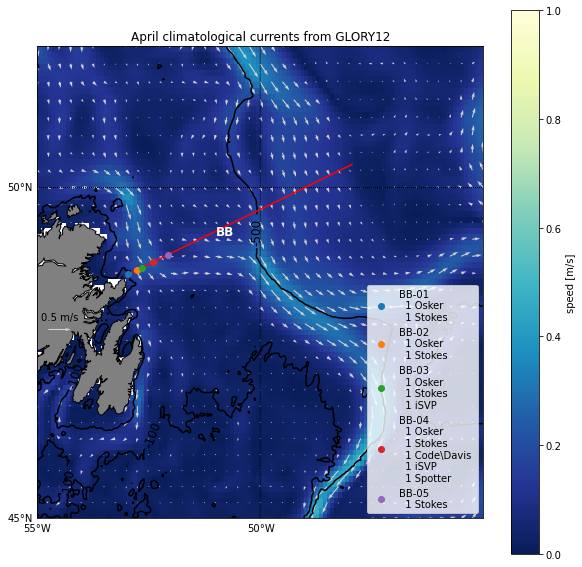

In [11]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
bmap = plot_map(ax)
plot_quivers(bmap, ax,uvel,vvel,lat, lon,st=3)
plot_transects(bmap, ax, transects)
plot_stations(bmap, ax, stations)
plot_bathymetry(bmap, ax, esel)
ax.text(0.4,0.6, 'BB', fontsize=12,color='w', transform=ax.transAxes,fontweight='bold')
ax.set_title('April climatological currents from GLORY12')
ax.legend()

/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/soontiensn/miniconda/envs/analysis/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: The following kwargs were not used by contour: 'linewidth'
  


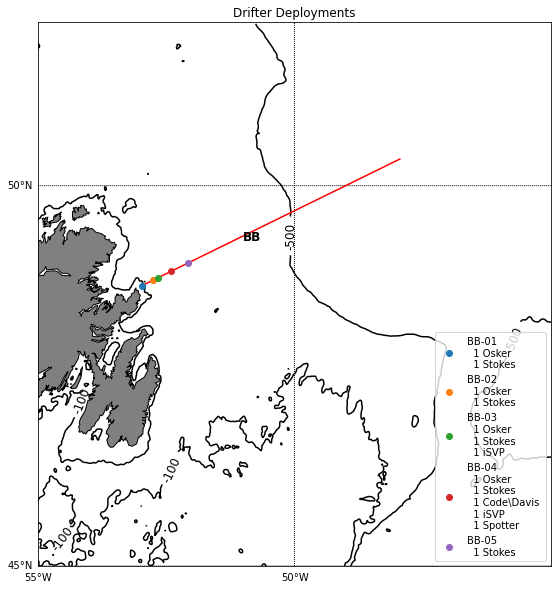

In [12]:
fig, ax = plt.subplots(1,1,figsize=(10,10))
bmap = plot_map(ax)
plot_transects(bmap, ax, transects)
plot_stations(bmap, ax, stations)
plot_bathymetry(bmap, ax, esel)
ax.text(0.4,0.6, 'BB', fontsize=12,color='k', transform=ax.transAxes,fontweight='bold')
ax.set_title('Drifter Deployments')
ax.legend()

TODO: Grab swath coordinates from Fred. Also along swath CTD track and mooring locations.